# Exploratory Data Analysis

In this notebook we will explore the data on the executives that we have found in Feature Generation pt1. and pt2.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

## 0. Preprocessing

In [2]:
# Load the executive feature file.
exec_features = pd.read_csv('./exec_features.csv', header=0)

# Load the company list with CEO and CFOs.
company_ceo_cfo = pd.read_csv('./Company_CEO_CFO.csv', header=0)

# Load the raw submissions for industry info (SIC).
with open( "dict_of_dfs_num_pre_sub_tag.p", "rb" ) as subs:
    dict_of_dfs_num_pre_sub_tag = pkl.load(subs)

In [3]:
# Load the cik and SIC (Industry) from the submission file.
cik_sic = dict_of_dfs_num_pre_sub_tag['SUB'][['cik', 'sic']].copy().drop_duplicates()

# Cast as integer for correct merging.
cik_sic['cik'] = cik_sic['cik'].astype(np.int64)

cik_sic.head(3)

,cik,sic
0,2178,5172
1,2488,3674
2,2969,2810


In [4]:
# Features have been extracted, no need to retain bios.
for col in ['bio_urls', 'bios']:
    if col in exec_features:
        exec_features.drop(col, axis=1, inplace=True)

In [5]:
# Merge the list of CEO/CFO by company with..
comp_ceo_cfo_sic_feat_ceo = company_ceo_cfo.merge(
    right=cik_sic, how='left', on='cik').merge( #.. the industry SIC table and
    right=exec_features, how='left', left_on='CEO', right_on='name') #.. the executive feature table.

In [6]:
# and clean it up.

comp_ceo_cfo_sic_feat_ceo = comp_ceo_cfo_sic_feat_ceo.drop(
    ['Unnamed: 0_x', 'adsh', 'filed', 'Unnamed: 0_y', 'name_y', 'title'], axis=1)
comp_ceo_cfo_sic_feat_ceo = comp_ceo_cfo_sic_feat_ceo.rename(columns={
    'name_x':'company_name',
    'age':'age_CEO',
    'gender':'gender_CEO',
    'degree':'degree_CEO',
    'awards':'awards_CEO',
    'career start':'career_start_CEO',
    'top university':'top_univ_CEO'})

In [7]:
# Do not analyze CEOs with no features (all NAs).
df_feats = comp_ceo_cfo_sic_feat_ceo.dropna(subset=['age_CEO', 'gender_CEO', 'degree_CEO', 'awards_CEO',
                                                     'career_start_CEO', 'top_univ_CEO'], how='all').copy()
# Identify the high-level industry.
df_feats['sic_1'] = df_feats['sic'].str[:1]

# Top-level industry categories
sic_descr = pd.DataFrame.from_dict({
    '0':' Agriculture, Forestry and Fishing',
    '1':' Mining, Oil and Heavy Construction',
    '2':' Manufacturing',
    '3':' Manufacturing',
    '4':' Transport., Comms. and Utilities',
    '5':' Wholesale and Retail',
    '6':' Finance and Insurance',
    '7':' Consumer Services and IT',
    '8':' Health, Legal and Prof. Services'
}, orient='index', columns=['ind_descr'])

df_feats = df_feats.merge(
    right=sic_descr, how='left', left_on='sic_1', right_index=True)

df_feats['industry_descr'] = df_feats['sic_1'].astype(str) + df_feats['ind_descr']
df_feats = df_feats.drop(['sic_1', 'ind_descr'], axis=1)

if not 'df_feats.csv' in os.listdir('.'):
    df_feats.to_csv('./df_feats.csv')

## 1. EDA

In [8]:
# Avoid lengthy pre-processing
try: df_feats
except NameError:
    df_feats = pd.read_csv('./df_feats.csv')

### 1.1 Age and Tenure (Career Length) by Industry

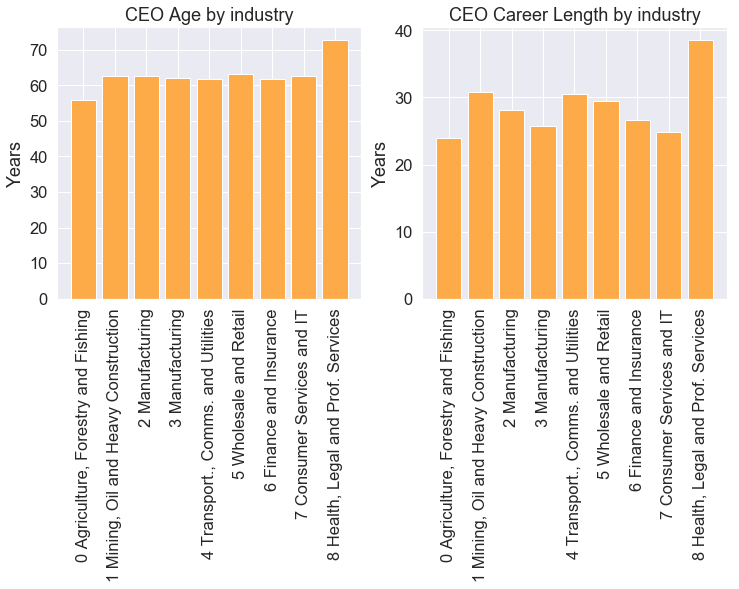

In [9]:
# CEO age by industry.
age_gr = df_feats[['industry_descr', 'age_CEO']].groupby('industry_descr')    

# Career length by industry.
df_feats['tenure'] = df_feats['fy'].astype(int) - df_feats['career_start_CEO']
career_gr = df_feats[['industry_descr', 'tenure']].groupby('industry_descr')

sns.set('notebook', font_scale=1.5, rc={'figure.figsize':(12,5)})

plt.subplot(1,2,1)
plt.bar(x=age_gr.mean().index, height=age_gr.mean()['age_CEO'], color='xkcd:light orange')
plt.xticks(rotation=90)
plt.ylabel('Years')
plt.title('CEO Age by industry')

plt.subplot(1,2,2)
plt.bar(x=career_gr.mean().index, height=career_gr.mean()['tenure'], color='xkcd:light orange')
plt.xticks(rotation=90)
plt.ylabel('Years')
plt.title('CEO Career Length by industry')

plt.show()

The average CEO in industry '8' (Health, Legal and Professional services) **is much older** than those in other industries (disregarding 0 with n=3).  

The Career Length chart supports this hypothesis: CEOs in industry 8 have been in their career for much longer (38 yrs) than in most other industries (25 to 31 yrs). This makes sense if they are older.  

To a lesser extent, the CEOs in industries 1 and 4 (Combined: Mining, Construction, Transportation, Communications, Electric, Gas and Sanitary service) appear **more experienced** than those in 3 and 7 (Combined: Manufacturing, B2C Services, IT).

### Hypotheses to test:
1. The average CEO in industries 1 and 4 has had a longer career than those in 3 and 7.

### 1.2 Education by Industry

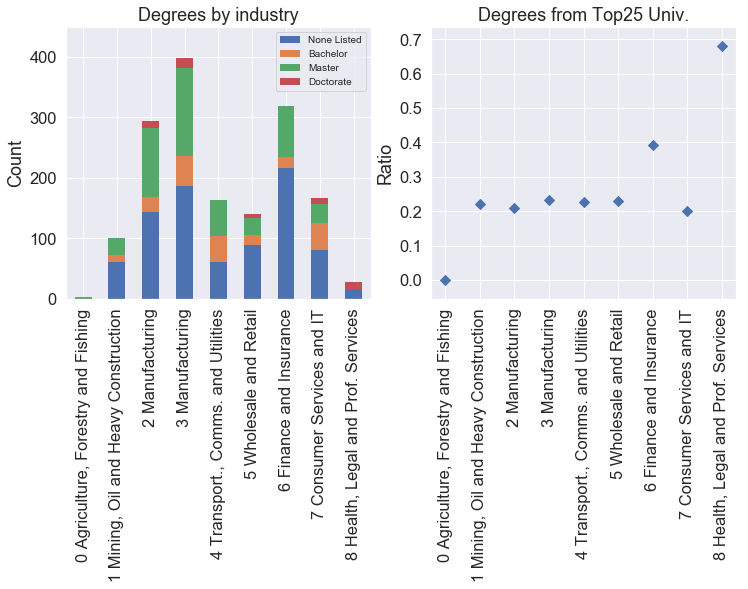

In [10]:
df_feats['degree_CEO'].fillna('None Listed', inplace=True)
degree_pivot = df_feats.pivot_table(index='industry_descr', 
                                    columns='degree_CEO', values='CEO', aggfunc='count')

# note: aggfunc='mean' fails on boolean values, not sure why. np.mean works though.
topuniv_pivot = df_feats.pivot_table(index='industry_descr', 
                                     values='top_univ_CEO', aggfunc=lambda x: np.mean(x))

fig, (ax1, ax2) = plt.subplots(1, 2)
degree_pivot[['None Listed', 'Bachelor', 'Master', 'Doctorate']].plot(
    use_index=True, kind="bar", ax=ax1, stacked=True, title='Degrees by industry', linewidth=0)
ax1.set_ylim(0,450)
ax1.set_xlabel(None)
ax1.set_ylabel('Count')
ax1.legend(prop={'size': 10})

ax2.scatter(x=topuniv_pivot.index, y=topuniv_pivot.top_univ_CEO, marker="D", s=50)
plt.xticks(rotation=90)
plt.ylabel('Ratio')
plt.title('Degrees from Top25 Univ.')

plt.show()

##### Generally, around half of the CEOs research do not have a degree listed, regardless of industry. Finance and Insurance are industries with the lowest percentage of degrees, but also the second-highest rate of degrees from a top-25 university.

For most industries around 20% of degrees were issued by Top25 global universities. For industry 8 (Health, Legal and Professional) this goes up to nearly 70%, albeit on a small sample size.

### 1.3 Awards by Industry

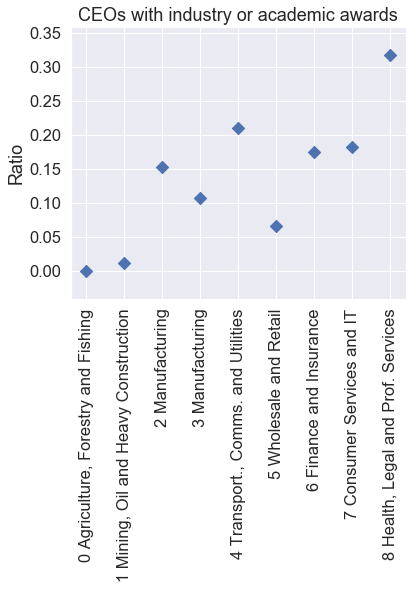

In [11]:
awards_pivot = df_feats.pivot_table(index='industry_descr', 
                                     values='awards_CEO', aggfunc=lambda x: np.mean(x))

sns.set('notebook', font_scale=1.5, rc={'figure.figsize':(6,5)})

plt.scatter(x=awards_pivot.index, y=awards_pivot.awards_CEO, marker="D", s=75)
plt.xticks(rotation=90)
plt.ylabel('Ratio')
plt.title('CEOs with industry or academic awards')
plt.show()

There is a significant difference in % of CEOs that have received an award between industries, ranging from <5% (industries 0, 1) to over 30% (industry 8).

### 1.4 Gender by Region

In [12]:
regions_dict = {
    'west_coast':['CA', 'OR', 'WA'],
    'east_coast':['PA', 'NJ', 'NY', 'CT', 'DE', 'MA', 'MD', 'RI', 'ME'],
    'mid_west':['MO', 'OH', 'IL', 'WI', 'NE', 'MI', 'KS', 'MN', 'IA', 'IN', 'ID'],
    'south':['NC', 'TX', 'FL', 'AL', 'SC', 'OK',  'AR', 'TN', 'LA', 'KY', 'GA', 'MS', 'VA'],
    'other':['CO', 'HI', 'NV', 'UT']
}

def region_from_state(stprba):
    '''Provides an interface to access regions_dict for Pandas Apply'''
    for k, v in regions_dict.items():
        if stprba in v:
            return k
    # The loop did not return a region? Return nan.
    return np.nan

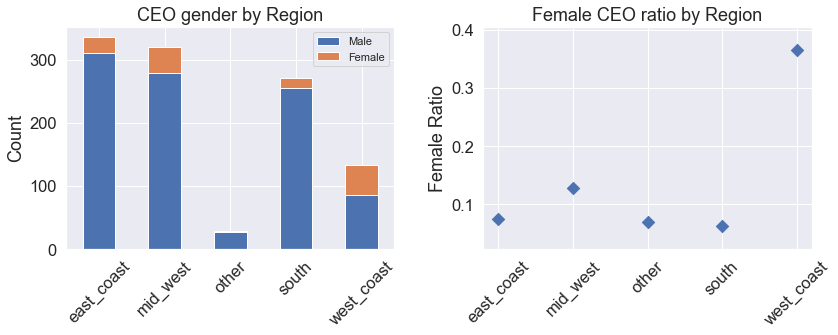

In [13]:
# Gender analysis by region.

df_feats['region'] = df_feats['stprba'].apply(region_from_state)

region_gender_pivot = df_feats.pivot_table(
    index='region', columns='gender_CEO', values='CEO', aggfunc='count')
region_gender_pivot['female_ratio'] = region_gender_pivot['Female'] / (
    region_gender_pivot['Male'] + region_gender_pivot['Female'])

sns.set('notebook', font_scale=1.5, rc={'figure.figsize':(12,5)})

fig, (ax1, ax2) = plt.subplots(1, 2)
region_gender_pivot[['Male', 'Female']].plot(
    use_index=True, kind="bar", ax=ax1, stacked=True, title='Gender by Region')
ax1.legend(prop={'size': 11})
ax1.xaxis.set_tick_params(rotation=45)
ax1.set_title('CEO gender by Region')
ax1.set_ylabel('Count')
ax1.set_xlabel(None)

ax2.scatter(x=region_gender_pivot.index, y=region_gender_pivot['female_ratio'], marker="D", s=75)
ax2.xaxis.set_tick_params(rotation=45)
plt.ylabel('Female Ratio')
plt.title('Female CEO ratio by Region')

plt.tight_layout()
plt.show()

About 1/3rd of West Coast CEOs are women, compared to ca. 10% in other regions.

## 2. Hypothesis testing

1. First Hypothesis:

**H0** There is no difference in tenure length between industries (1, 4) and (3, 7).  
**H1** The average CEO of industries 1 and 4 has had a longer tenure than 3 and 7.

In [14]:
ind_1_4 = df_feats[['industry_descr', 'tenure']][df_feats['industry_descr'].isin(
    ['1 Mining, Oil and Heavy Construction', '4 Transport., Comms. and Utilities'])].dropna()

ind_3_7 = df_feats[['industry_descr', 'tenure']][df_feats['industry_descr'].isin(
    ['3 Manufacturing', '7 Consumer Services and IT'])].dropna()

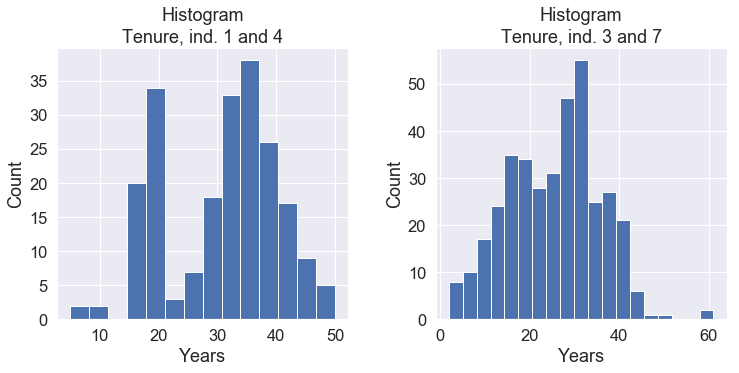

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ind_1_4.hist(bins=int(len(ind_1_4)**0.5), ax=ax1)
ax1.set_title('Histogram\nTenure, ind. 1 and 4')
ax1.set_xlabel('Years')
ax1.set_ylabel('Count')
ind_3_7.hist(bins=int(len(ind_3_7)**0.5), ax=ax2)
ax2.set_title('Histogram\nTenure, ind. 3 and 7')
ax2.set_xlabel('Years')
ax2.set_ylabel('Count')
plt.show()

For industries 1,4, the tenure distribution is actually bimodal. This is also true for 3,7, but to a lesser extent.

Break the problem up in 2 smaller problems:  
(1) Perform hypothesis testing for tenures > 25 (after the first peak).  
(2) Investigate what sets the short-tenured CEOs apart from the long-tenured CEOs.

In [16]:
# 1. Perform hypothesis test
from scipy.stats import ttest_ind

ind_1_4_over_25 = ind_1_4[ind_1_4['tenure'] > 25]
ind_3_7_over_25 = ind_3_7[ind_3_7['tenure'] > 25]

T, p = ttest_ind(ind_1_4_over_25['tenure'], ind_3_7_over_25['tenure'], equal_var=False)

print('p_value=%.2f' % p)
if p < 0.05:
    print('Reject the 0H: mean tenures (over 25 years) are not equal')
else:
    print('Accept the 0H: mean tenures (over 25 years) are equal')

p_value=0.00
Reject the 0H: mean tenures (over 25 years) are not equal


                         Features  Importance
6               degree_CEO_Master    0.662632
1  industry_descr_3 Manufacturing    0.337368


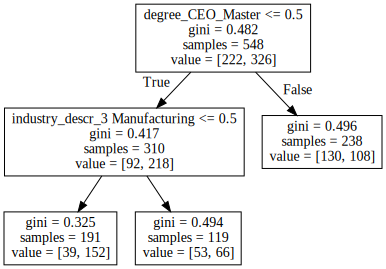

In [17]:
# 2. Compare short-tenured CEOs and Long-tenured CEOs.
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
# To vizualize the decision tree
import graphviz

# Make a Boolean column: tenure over 25yrs.
df_feats['long_tenured'] = df_feats['tenure'].apply(lambda x: x > 25)
# Select the relevant columns.
df_feats_1347 = df_feats[df_feats['industry_descr'].isin(
    ['1 Mining, Oil and Heavy Construction', '4 Transport., Comms. and Utilities', 
     '3 Manufacturing', '7 Consumer Services and IT'])]
# SKlearn's decision tree does not handle NaNs.
df_feats_nonan = df_feats_1347.dropna()

y = df_feats_nonan['long_tenured']
X = df_feats_nonan[['gender_CEO', 'industry_descr', 'top_univ_CEO', 'degree_CEO']]

# This encodes the categorical features to individual columns 
# (eg. gender_CEO(Categorical) --> gender_CEO_Male(Bool))
# This is necessary for SKlearn's decision tree classifier.
one_hot_data = pd.get_dummies(X,drop_first=True)

tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=100)
tree.fit(one_hot_data, y)

feature_imp = pd.DataFrame({'Features':one_hot_data.columns, 'Importance':tree.feature_importances_})
feature_imp = feature_imp[feature_imp['Importance'] > 0].sort_values('Importance', ascending=False)
print(feature_imp)

dot_data = export_graphviz(tree, out_file=None, feature_names=one_hot_data.columns) 
graph = graphviz.Source(dot_data) 
graph

### 2.1 Conclusions on CEO Tenure (career length)

A histogram reveals that for industries 1,3,4 and 7 CEO Tenure (career length) is **bimodal**. It is either <25 or >30. The hypothesis test confirmed that the average tenure **OVER 30** differs between industries 1, 4 (ca. 35) and 3, 7 (ca. 30).

A decision tree classifier reveals that the most important determinants of a Career Length under 25 years are:  
* the CEO holds a Master's degree, and 
* the CEO is active in industry 3 (Manufacturing).  

This could be interpreted that persons holding a Master's Degree are more likely to grow to CEO before the 25th year of their career, whereas Bachelor's or persons holding no degree would grow to this role by the 30 or 35th year of their career, dependent on industry. The Manufacturing industry (SIC starting with 3- ) in general appears more open to younger CEOs.